# start

from 0320_3; grid search;

- https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py
- https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
- https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

In [74]:
PRFX='0320_5'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])

params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss', 'auc', 'aucpr',],
    'max_delta_step': 1,
}
num_rounds = 800

['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [75]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [76]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [77]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [78]:
grand_total

150000000.0

In [79]:
grand_total/1e6

150.0

In [80]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e4#1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-21 01:08:18 chunk 0


In [81]:
df = pd.concat(lst_df)

In [82]:
df.shape

(10000, 29)

In [83]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

In [84]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [85]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 5.29 ms, sys: 4.46 ms, total: 9.76 ms
Wall time: 8.09 ms


In [86]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((8500, 25), (1500, 25), (8500, 4), (1500, 4))

In [91]:
bst = xgb.XGBClassifier(objective='binary:logistic')
clf = GridSearchCV(bst,
                   {'n_estimators': [5, 7]}, 
                   verbose=2)
clf.fit(Xtr,ytr.iloc[:,0])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=2, n_estimators=5 .....................................
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] IN

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[CV] ...................... max_depth=2, n_estimators=5, total=   0.1s
[CV] max_depth=2, n_estimators=5 .....................................
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:09:49] INFO: /workspa

[CV] ...................... max_depth=4, n_estimators=5, total=   0.1s
[CV] max_depth=4, n_estimators=5 .....................................
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[CV] ...................... max_depth=4, n_estimators=5, total=   0.1s
[CV] max_depth=4, n_estimators=7 .....................................
[01:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_dept

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                   

In [92]:
print(clf.best_score_)
print(clf.best_params_)


0.012786889554495917
{'max_depth': 4, 'n_estimators': 7}


In [94]:
clf.predict_proba(Xvl)

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

# model

In [28]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 20:21:05 Retweet ********************************************************************************
[20:21:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-error:0.10988	train-logloss:0.58731	train-auc:0.50738	train-aucpr:0.12893	eval-error:0.11667	eval-logloss:0.58945	eval-auc:0.50772	eval-aucpr:0.13620
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 10 rounds.
[20:21:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.10953	train-logloss:0.50165	train-auc:0.54816	train-aucpr:0.21002	eval-error:0.11667	eval-logloss:0.50993	eval-auc:0.51185	eval-aucpr:0.13540
[20:21:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.10812	train-logloss:0.43599	train-auc:0.60431	tr

[20:21:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[29]	train-error:0.08694	train-logloss:0.21112	train-auc:0.95422	train-aucpr:0.80282	eval-error:0.12400	eval-logloss:0.35665	eval-auc:0.65260	eval-aucpr:0.19270
[20:21:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-error:0.08588	train-logloss:0.20934	train-auc:0.95630	train-aucpr:0.81157	eval-error:0.12400	eval-logloss:0.35753	eval-auc:0.65075	eval-aucpr:0.19190
[20:21:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-error:0.08541	train-logloss:0.20597	train-auc:0.95927	train-aucpr:0.82299	eval-error:0.12400	eval-logloss:0.35795	eval-auc:0.65139	eval-aucpr:0.19259
[20:21:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.08353	train-loglos

[20:21:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[19]	train-error:0.02706	train-logloss:0.07496	train-auc:0.97467	train-aucpr:0.70259	eval-error:0.02533	eval-logloss:0.11452	eval-auc:0.68989	eval-aucpr:0.04957
[20:21:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[20]	train-error:0.02659	train-logloss:0.07208	train-auc:0.97865	train-aucpr:0.73964	eval-error:0.02533	eval-logloss:0.11551	eval-auc:0.68555	eval-aucpr:0.04541
[20:21:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21]	train-error:0.02624	train-logloss:0.06980	train-auc:0.98256	train-aucpr:0.77055	eval-error:0.02533	eval-logloss:0.11737	eval-auc:0.67012	eval-aucpr:0.04334
[20:21:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-error:0.02612	train-loglos

[20:21:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[20]	train-error:0.24588	train-logloss:0.51401	train-auc:0.84212	train-aucpr:0.80795	eval-error:0.32600	eval-logloss:0.61513	eval-auc:0.72006	eval-aucpr:0.66245
[20:21:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21]	train-error:0.24329	train-logloss:0.51111	train-auc:0.84517	train-aucpr:0.81262	eval-error:0.32733	eval-logloss:0.61606	eval-auc:0.71925	eval-aucpr:0.66209
[20:21:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-error:0.24294	train-logloss:0.51052	train-auc:0.84552	train-aucpr:0.81328	eval-error:0.32867	eval-logloss:0.61604	eval-auc:0.71929	eval-aucpr:0.66233
[20:21:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-error:0.23977	train-loglos

In [29]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


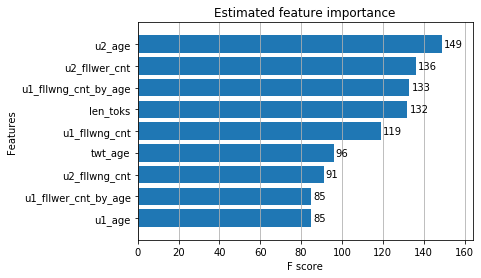

,0,1
3,u2_age,149
1,u2_fllwer_cnt,136
8,u1_fllwng_cnt_by_age,133
0,len_toks,132
4,u1_fllwng_cnt,119
7,twt_age,96
5,u2_fllwng_cnt,91
10,u1_fllwer_cnt_by_age,85
9,u1_age,85
13,tmdlta_u2u1,74


Reply


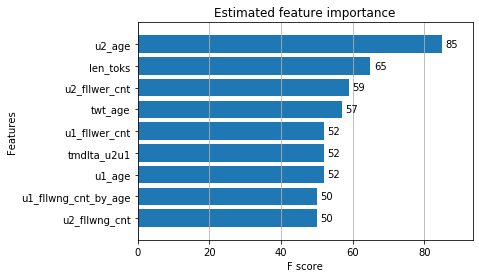

,0,1
3,u2_age,85
9,len_toks,65
10,u2_fllwer_cnt,59
2,twt_age,57
4,tmdlta_u2u1,52
1,u1_age,52
6,u1_fllwer_cnt,52
11,u1_fllwng_cnt_by_age,50
7,u2_fllwng_cnt,50
0,u1_fllwer_cnt_by_age,45


Like


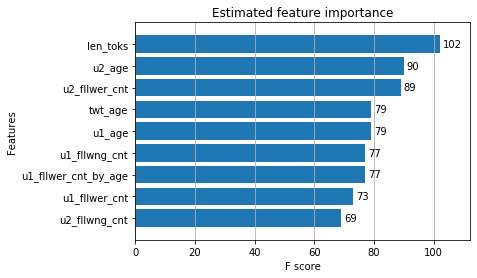

,0,1
3,len_toks,102
12,u2_age,90
8,u2_fllwer_cnt,89
7,u1_age,79
9,twt_age,79
11,u1_fllwng_cnt,77
4,u1_fllwer_cnt_by_age,77
5,u1_fllwer_cnt,73
10,u2_fllwng_cnt,69
2,u1_fllwng_cnt_by_age,64


RTwCmnt


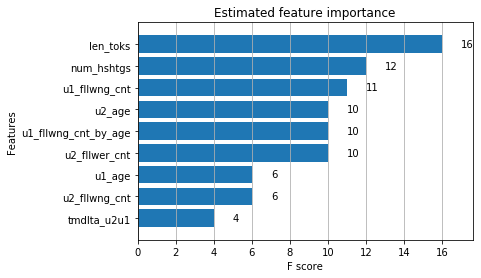

,0,1
6,len_toks,16
1,num_hshtgs,12
5,u1_fllwng_cnt,11
0,u2_fllwer_cnt,10
2,u1_fllwng_cnt_by_age,10
3,u2_age,10
12,u2_fllwng_cnt,6
14,u1_age,6
8,tm_hour,4
9,u1_fllwer_cnt,4


In [30]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

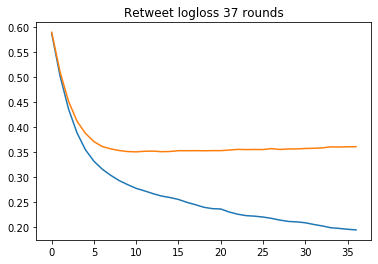

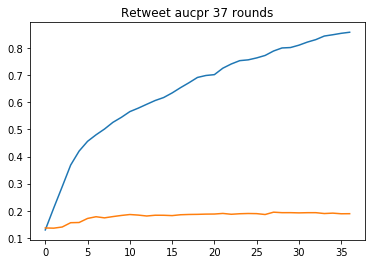

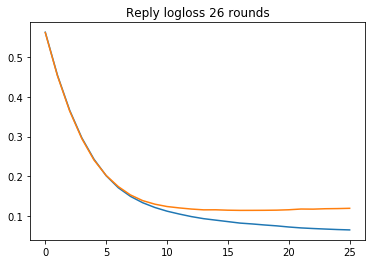

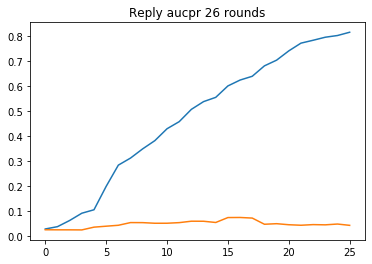

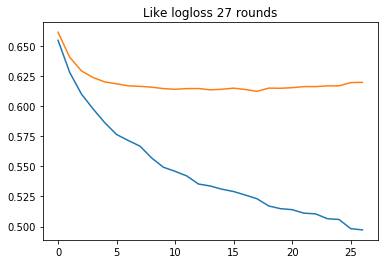

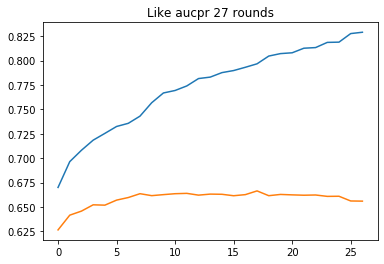

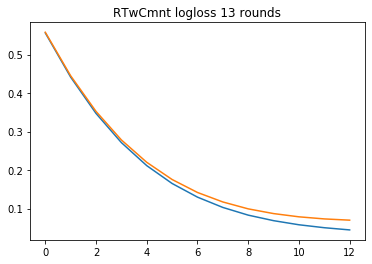

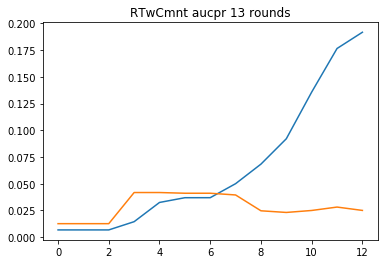

In [39]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
#     plt.plot(evalres['train']['error'])
#     plt.plot(evalres['eval']['error'])
#     plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
#     plt.show()
#     plt.plot(evalres['train']['auc'])
#     plt.plot(evalres['eval']['auc'])
#     plt.title(f"{tgt} auc {len(evalres['train']['auc'])} rounds")
#     plt.show()    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

In [40]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 20:25:08 Retweet
2020-03-20 20:25:08 Reply
2020-03-20 20:25:08 Like
2020-03-20 20:25:08 RTwCmnt


In [41]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.9690 valid auc: 0.6465
train prauc: 0.8617 valid auc: 0.1886
train rce: 44.3620 valid rce: 0.3508
Reply
train rocauc: 0.9897 valid auc: 0.6672
train prauc: 0.8359 valid auc: 0.0433
train rce: 51.4088 valid rce: -0.7417
Like
train rocauc: 0.8609 valid auc: 0.7152
train prauc: 0.8316 valid auc: 0.6554
train rce: 27.9744 valid rce: 9.8282
RTwCmnt
train rocauc: 0.8791 valid auc: 0.5425
train prauc: 0.2339 valid auc: 0.0258
train rce: 0.5654 valid rce: -0.2012


In [42]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.861748,44.362,0.835903,51.4088,0.831615,27.9744,0.233888,0.565399
scrval,0.188572,0.350788,0.0433342,-0.741687,0.655412,9.82817,0.0258407,-0.20121


# infer

In [37]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


KeyboardInterrupt: 

In [38]:
%%time
dftst = prp_df(dftst, istrn=False)

NameError: name 'dftst' is not defined

In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 16:28:21 Retweet
2020-03-20 16:28:34 Reply
2020-03-20 16:28:39 Like
2020-03-20 16:29:33 RTwCmnt
CPU times: user 19min 49s, sys: 12.8 s, total: 20min 2s
Wall time: 1min 53s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 16:29:38 Retweet
2020-03-20 16:30:34 Reply
2020-03-20 16:31:31 Like
2020-03-20 16:32:26 RTwCmnt
CPU times: user 3min 37s, sys: 6.78 s, total: 3min 44s
Wall time: 3min 45s
